In [20]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
# 改成你其中一个文件的路径
sample_path = "~/Desktop/Cases_1/苏州工业园/Electric power load data/2019/1_hour/2019_1hour_Office/20190101_1hour_Office.xlsx"
sample_path = os.path.expanduser(sample_path)

# 读取文件头部几行
df = pd.read_excel(sample_path)
print("列名如下：")
print(df.columns)

# 设置文件夹路径
folder_path = os.path.expanduser("~/Desktop/Cases_1/苏州工业园/Electric power load data/2019/1_hour/2019_1hour_Office")

# 获取所有 .xlsx 文件
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])

# 创建空 DataFrame 用于合并
combined_df = pd.DataFrame()

列名如下：
Index(['Time', 'Power (kW)'], dtype='object')


In [22]:
# 遍历每个文件
for filename in file_list:
    try:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')  # 显式指定 engine
        
        # 标准化列名
        df.columns = [col.strip().replace('\n', '').replace('\r', '').lower() for col in df.columns]
        #  print(f"✔ 读取 {filename} 的列名为：{df.columns.tolist()}")
        
        # 判断列名是否存在
        if 'time' in df.columns and 'power (kw)' in df.columns:
            df = df[['time', 'power (kw)']]
            df['SourceFileDate'] = filename[:8]
            
            # 转换类型
            df['time'] = pd.to_datetime(df['time'])
            df['SourceFileDate'] = pd.to_datetime(df['SourceFileDate'])
            
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            raise ValueError("列名不符合预期：'time' 和 'power (kw)' 不存在")
    
    except Exception as e:
        print(f"跳过文件 {filename}, 原因: {e}")


# 保存最终合并的 CSV
combined_df.to_csv("Office_2019_1hour_long.csv", index=False)
print("成功导出为 'Office_2019_1hour_long.csv'")

成功导出为 'Office_2019_1hour_long.csv'


In [23]:
df = pd.read_csv("Office_2019_1hour_long.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower() for col in df.columns]  # 统一小写 + 去空格

# 统一时间格式
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.time

# 去重，只保留第一条记录
df = df.drop_duplicates(subset=['date', 'hour'], keep='first')

# 生成每天一行，每小时一列的负载矩阵
pivot_df = df.pivot(index='date', columns='hour', values='power (kw)').reset_index()
pivot_df.to_csv("daily_load_matrix.csv", index=False)

print("已成功生成 daily_load_matrix.csv（重复已处理）")

已成功生成 daily_load_matrix.csv（重复已处理）


In [24]:
pivot_df = pd.read_csv("daily_load_matrix.csv")
# 插值 + 双向填充
pivot_df_interp = pivot_df.set_index('date')
pivot_df_interp = pivot_df_interp.interpolate(axis=1, limit_direction='both')
pivot_df_interp = pivot_df_interp.ffill(axis=1).bfill(axis=1)

# 丢掉真的没救的数据（全为空行）
pivot_df_interp = pivot_df_interp.dropna(thresh=10)  # 至少保留10小时数据
pivot_df_interp = pivot_df_interp.reset_index()

In [25]:
pivot_df_interp.shape     
pivot_df_interp.head()

,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2019-01-01,204.72,207.00,204.48,208.80,203.04,207.36,231.60,220.08,332.88,...,363.24,348.00,359.16,335.52,379.80,357.84,314.40,347.76,207.72,206.04
1,2019-01-02,203.76,206.40,191.64,199.20,199.20,202.20,812.16,897.84,1088.76,...,1301.64,1166.76,1205.64,1208.88,641.04,510.60,423.48,349.08,233.28,228.48
2,2019-01-03,225.36,219.96,224.28,210.84,217.20,213.96,844.56,927.00,1129.68,...,1225.32,1183.20,1158.72,1173.72,602.40,485.88,447.84,376.44,257.52,219.00
3,2019-01-04,223.08,220.56,229.44,218.76,219.60,222.60,815.40,912.72,1109.28,...,1179.12,1089.48,1073.16,1087.68,653.40,483.96,420.12,344.16,240.24,269.16
4,2019-01-05,209.52,212.76,241.80,212.28,207.96,204.12,236.76,250.20,360.12,...,465.84,512.64,494.52,466.44,543.36,402.60,387.36,385.80,257.40,222.48


In [26]:
X = pivot_df_interp.select_dtypes(include='number')
print(X.isna().sum().sum())  # 输出所有 NaN 的总数

0


In [27]:
X = pivot_df_interp.select_dtypes(include='number')  # 数值型列，即每小时负载值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pivot_df_interp['cluster'] = clusters  # 添加聚类标签

# 正确保存
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels.csv", index=False)

In [28]:
print(pivot_df_interp[['date', 'cluster']].head())

         date  cluster
0  2019-01-01        0
1  2019-01-02        1
2  2019-01-03        1
3  2019-01-04        1
4  2019-01-05        0


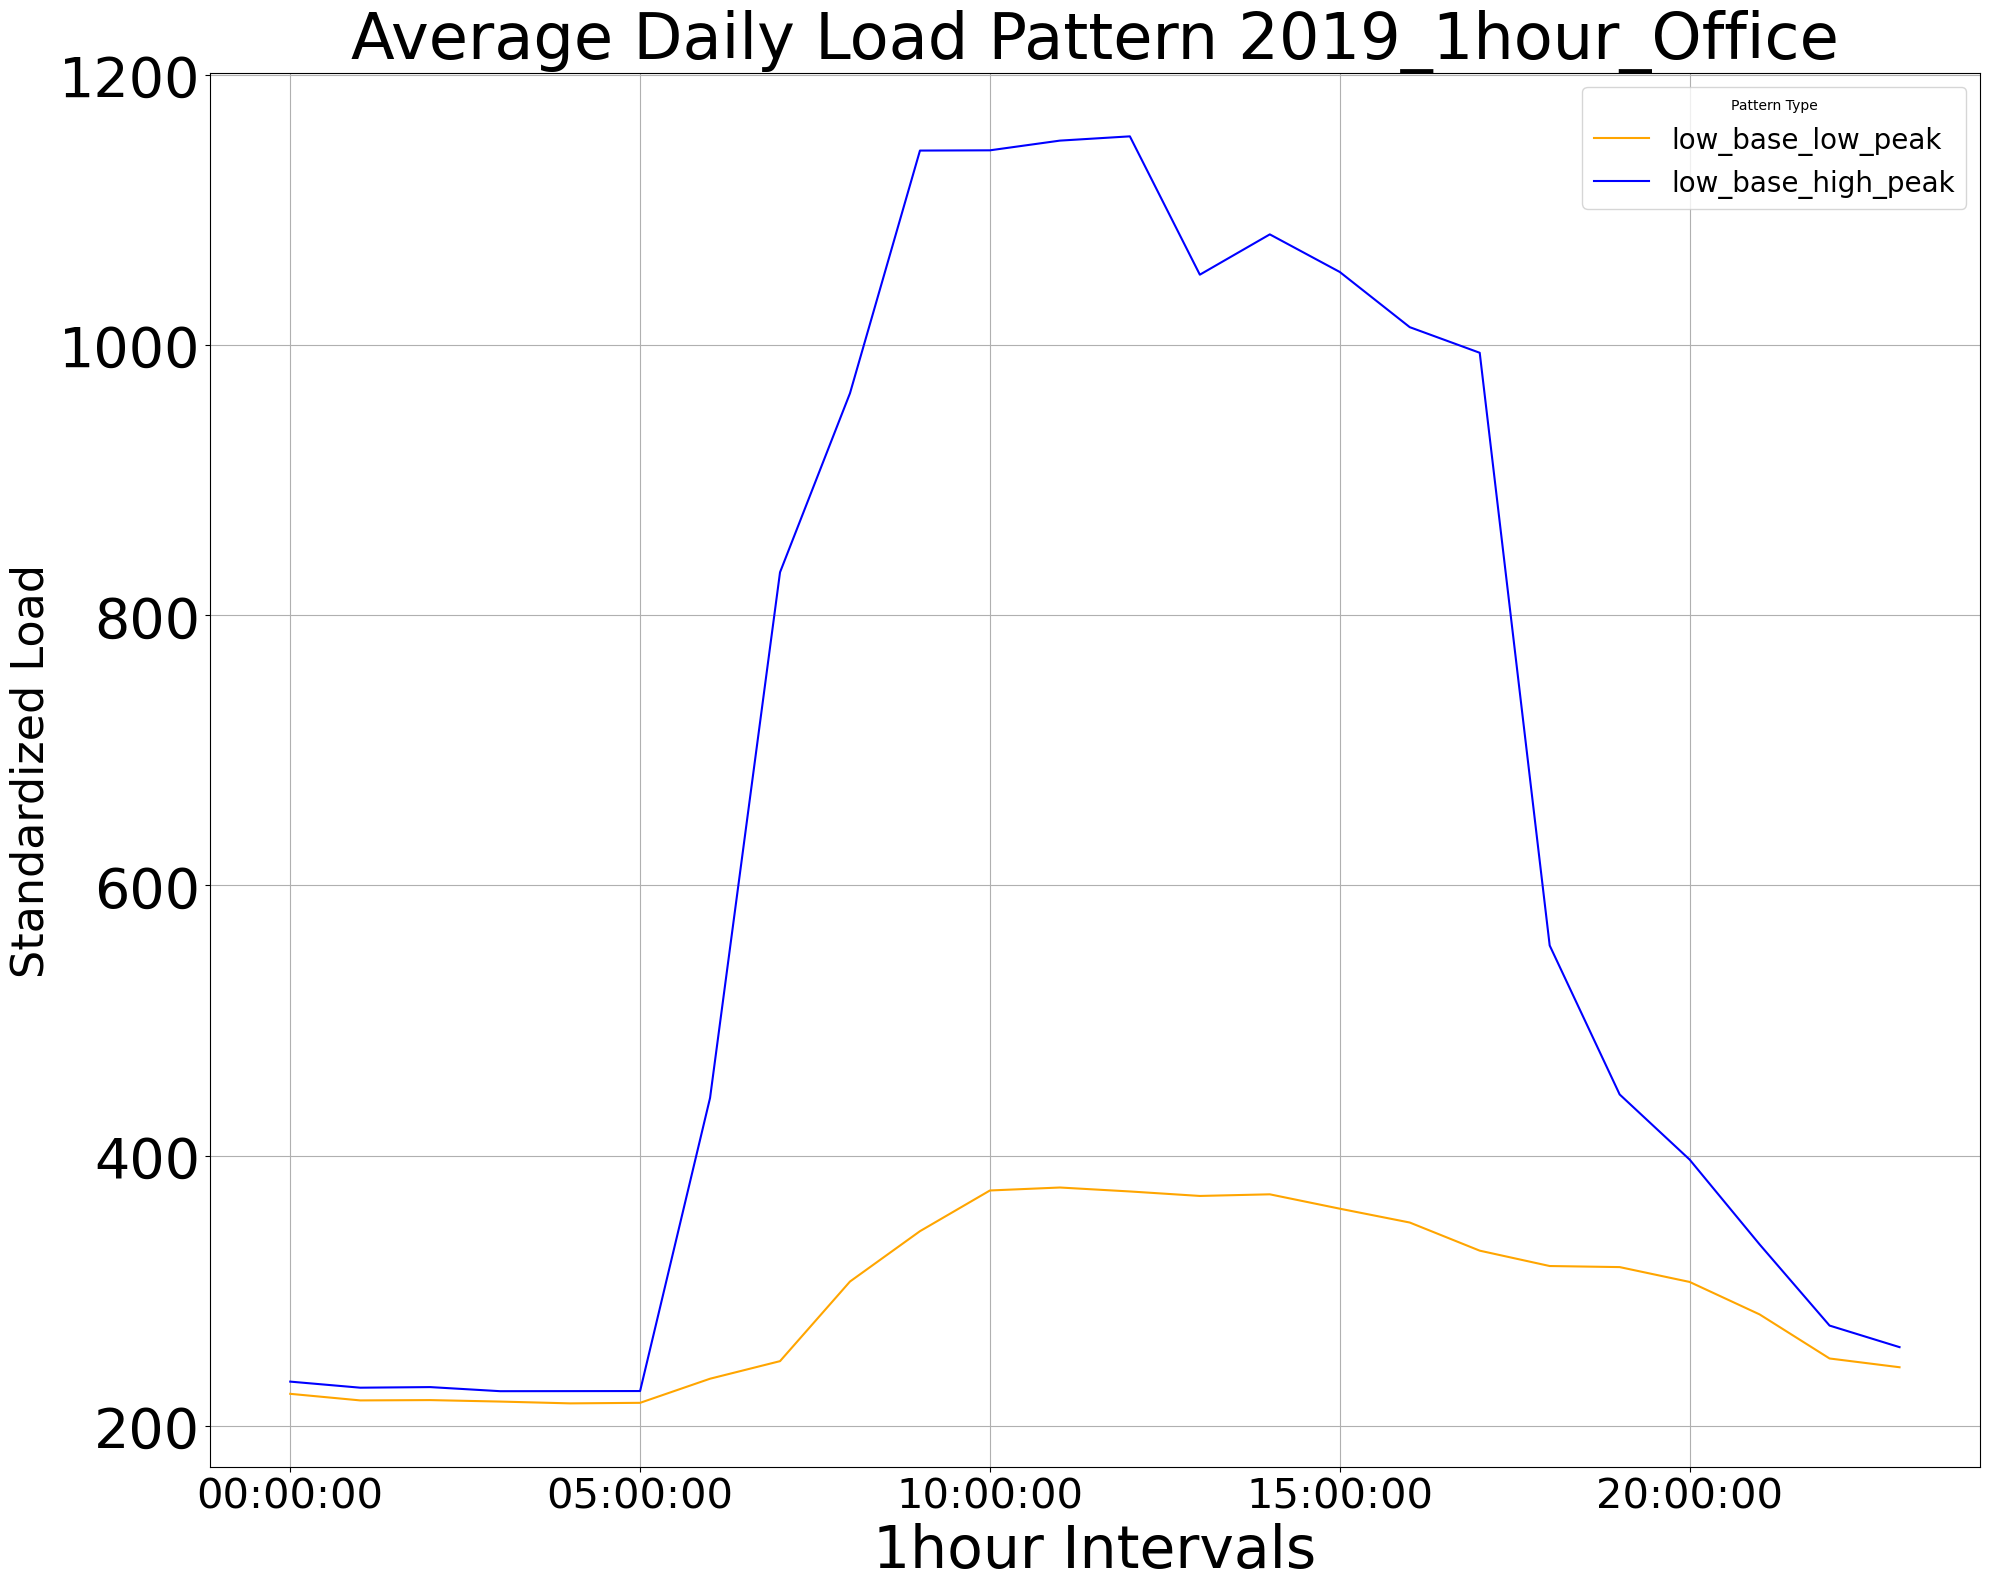

In [29]:
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')

# Ensure clustering has been done and column exists
assert 'cluster' in pivot_df_interp.columns, "Missing 'cluster' column. Run KMeans first."

# Group by cluster, average the first 96 load columns
avg_by_label = pivot_df_interp.groupby("cluster")[load_columns].mean()

# Define custom labels
cluster_name_map = {
    0: "low_base_low_peak",
    1: "low_base_high_peak",
}
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)

# Define custom color mapping
color_map = {
    "low_base_low_peak": "orange",
    "low_base_high_peak": "blue",
    "high_morning_low_afternoon": "gray"  # Default color
}
# Map the colors in the same order as avg_by_label rows
colors = [color_map.get(name, 'gray') for name in avg_by_label.index]

# Plot
avg_by_label.T.plot(figsize=(20, 16), color=colors)
plt.title("Average Daily Load Pattern 2019_1hour_Office", fontsize=46)
plt.xlabel("1hour Intervals", fontsize=42)
plt.ylabel("Standardized Load", fontsize=32)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
cluster_name_map = {
    0: "low_base_high_peak",
    1: "low_base_low_peak",
}

for c in sorted(pivot_df_interp['cluster'].unique()):
    name = cluster_name_map[c]
    print(f"\nCluster {c} ({name}):")
    dates = pivot_df_interp[pivot_df_interp['cluster'] == c]['date'].tolist()
    print(dates[:360])



Cluster 0 (low_base_high_peak):
[Timestamp('2019-01-01 00:00:00'), Timestamp('2019-01-05 00:00:00'), Timestamp('2019-01-06 00:00:00'), Timestamp('2019-01-19 00:00:00'), Timestamp('2019-01-20 00:00:00'), Timestamp('2019-01-26 00:00:00'), Timestamp('2019-01-27 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-05 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-07 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-09 00:00:00'), Timestamp('2019-02-10 00:00:00'), Timestamp('2019-02-16 00:00:00'), Timestamp('2019-02-17 00:00:00'), Timestamp('2019-02-23 00:00:00'), Timestamp('2019-02-24 00:00:00'), Timestamp('2019-03-02 00:00:00'), Timestamp('2019-03-03 00:00:00'), Timestamp('2019-03-09 00:00:00'), Timestamp('2019-03-10 00:00:00'), Timestamp('2019-03-16 00:00:00'), Timestamp('2019-03-17 00:00:00'), Timestamp('2019-03-23 00:00:00'), Timestamp('2019-03-24 00:00:00'), Timestamp('2019-03-30 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('201

In [31]:
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2019_1hour_office.csv")

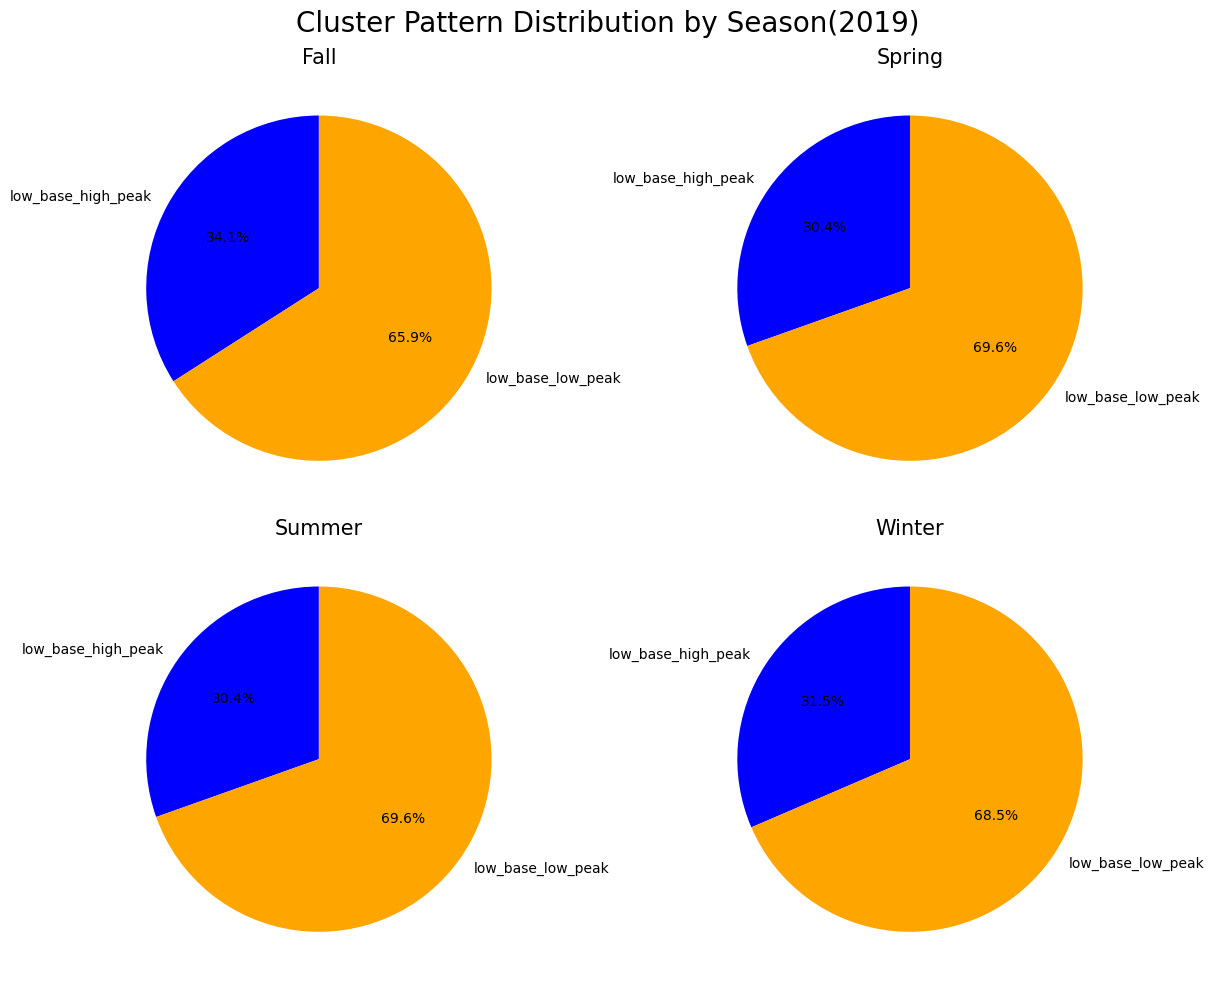

In [41]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)
pattern_by_season = pivot_df_interp.groupby(['season', 'pattern']).size().unstack(fill_value=0)


seasons = pattern_by_season.index.tolist()
labels = pattern_by_season.columns.tolist()

# Define color mapping
color_dict = {
    'low_base_low_peak': 'orange',
    'low_base_high_peak': 'blue'
}
# Assign default color if pattern not in the dictionary
colors = [color_dict.get(label, 'gray') for label in labels]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of pie charts

for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]
    ax.pie(
        pattern_by_season.loc[season], 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=colors
    )
    ax.set_title(f"{season}",fontsize=15)
plt.suptitle("Cluster Pattern Distribution by Season(2019)",fontsize=20)
plt.tight_layout()
plt.show()

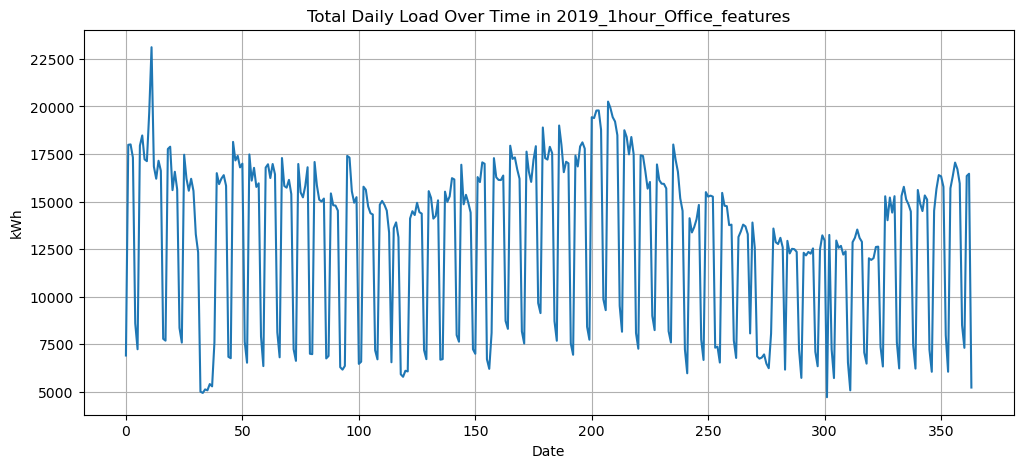

In [33]:
# 1. 完成所有预处理（插值、聚类、添加 pattern 和 season）
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. 必须在这里清洗列名！所有后续都基于它！
pivot_df_interp.columns = pivot_df_interp.columns.map(str)

# 3. 抓负载列（非 date / cluster / pattern / season）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

# 4. 提取特征（注意 idxmax 前，列名必须是 string）
features_df = pd.DataFrame(index=pivot_df_interp.index)
features_df["total_load"] = pivot_df_interp[load_columns].sum(axis=1)
features_df["peak_load"] = pivot_df_interp[load_columns].max(axis=1)
features_df["valley_load"] = pivot_df_interp[load_columns].min(axis=1)
features_df["load_range"] = features_df["peak_load"] - features_df["valley_load"]
features_df["load_std"] = pivot_df_interp[load_columns].std(axis=1)
features_df["time_of_peak"] = pivot_df_interp[load_columns].idxmax(axis=1)
features_df["time_of_valley"] = pivot_df_interp[load_columns].idxmin(axis=1)

# 5.把时间截干净
features_df["time_of_peak"] = features_df["time_of_peak"].str[-8:]
features_df["time_of_valley"] = features_df["time_of_valley"].str[-8:]
features_df["total_load"].plot(figsize=(12, 5), title="Total Daily Load Over Time in 2019_1hour_Office_features")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.grid(True)
plt.show()

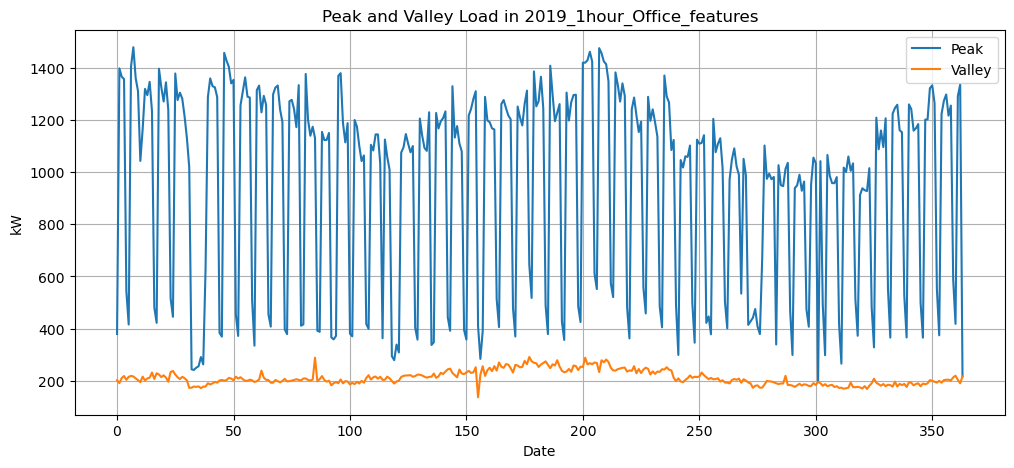

In [34]:
features_df[["peak_load", "valley_load"]].plot(figsize=(12, 5), title="Peak and Valley Load in 2019_1hour_Office_features")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend(["Peak", "Valley"])
plt.grid(True)
plt.show()

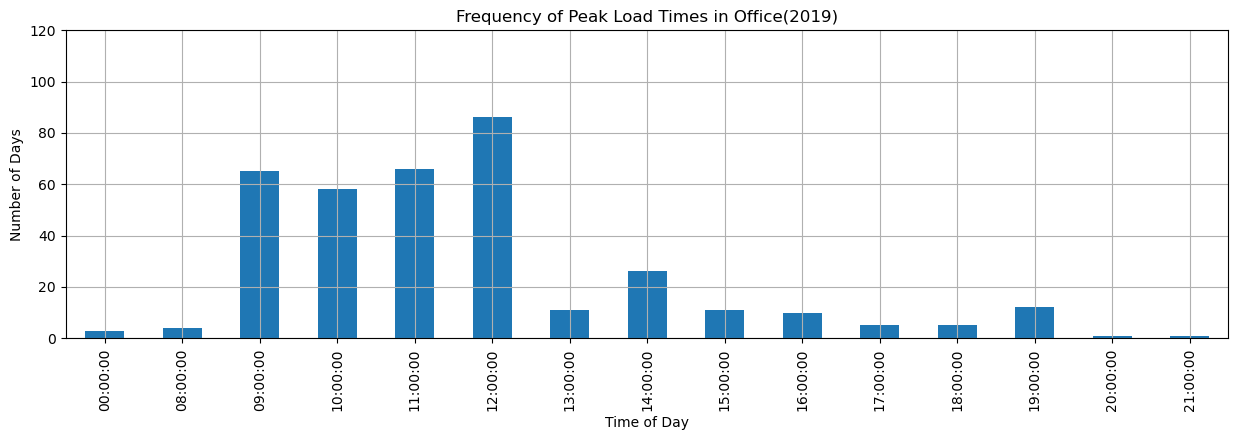

In [35]:
features_df["time_of_peak"].value_counts().sort_index().plot(kind="bar", figsize=(15, 4), title="Frequency of Peak Load Times in Office(2019)")
plt.xlabel("Time of Day")
plt.ylabel("Number of Days")
plt.ylim(0,120)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

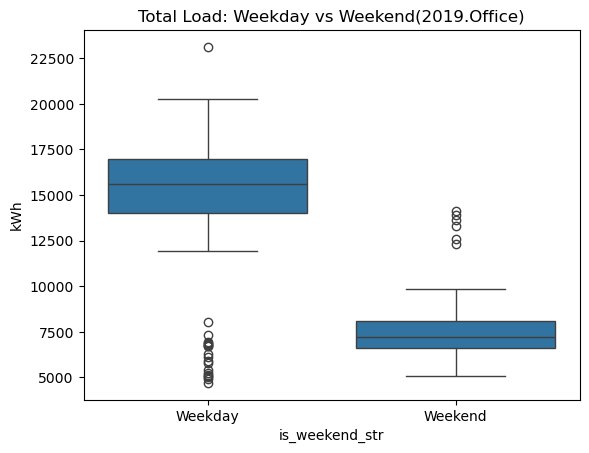

In [40]:
features_df['is_weekend'] = pivot_df_interp['date'].dt.weekday >= 5
features_df['is_weekend_str'] = features_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
features_df["is_weekend_str"] = features_df["is_weekend"].map({True: "Weekend", False: "Weekday"})
sns.boxplot(x="is_weekend_str", y="total_load", data=features_df)
plt.title("Total Load: Weekday vs Weekend(2019.Office)")
plt.ylabel("kWh")
plt.show()

<Figure size 1600x1000 with 0 Axes>

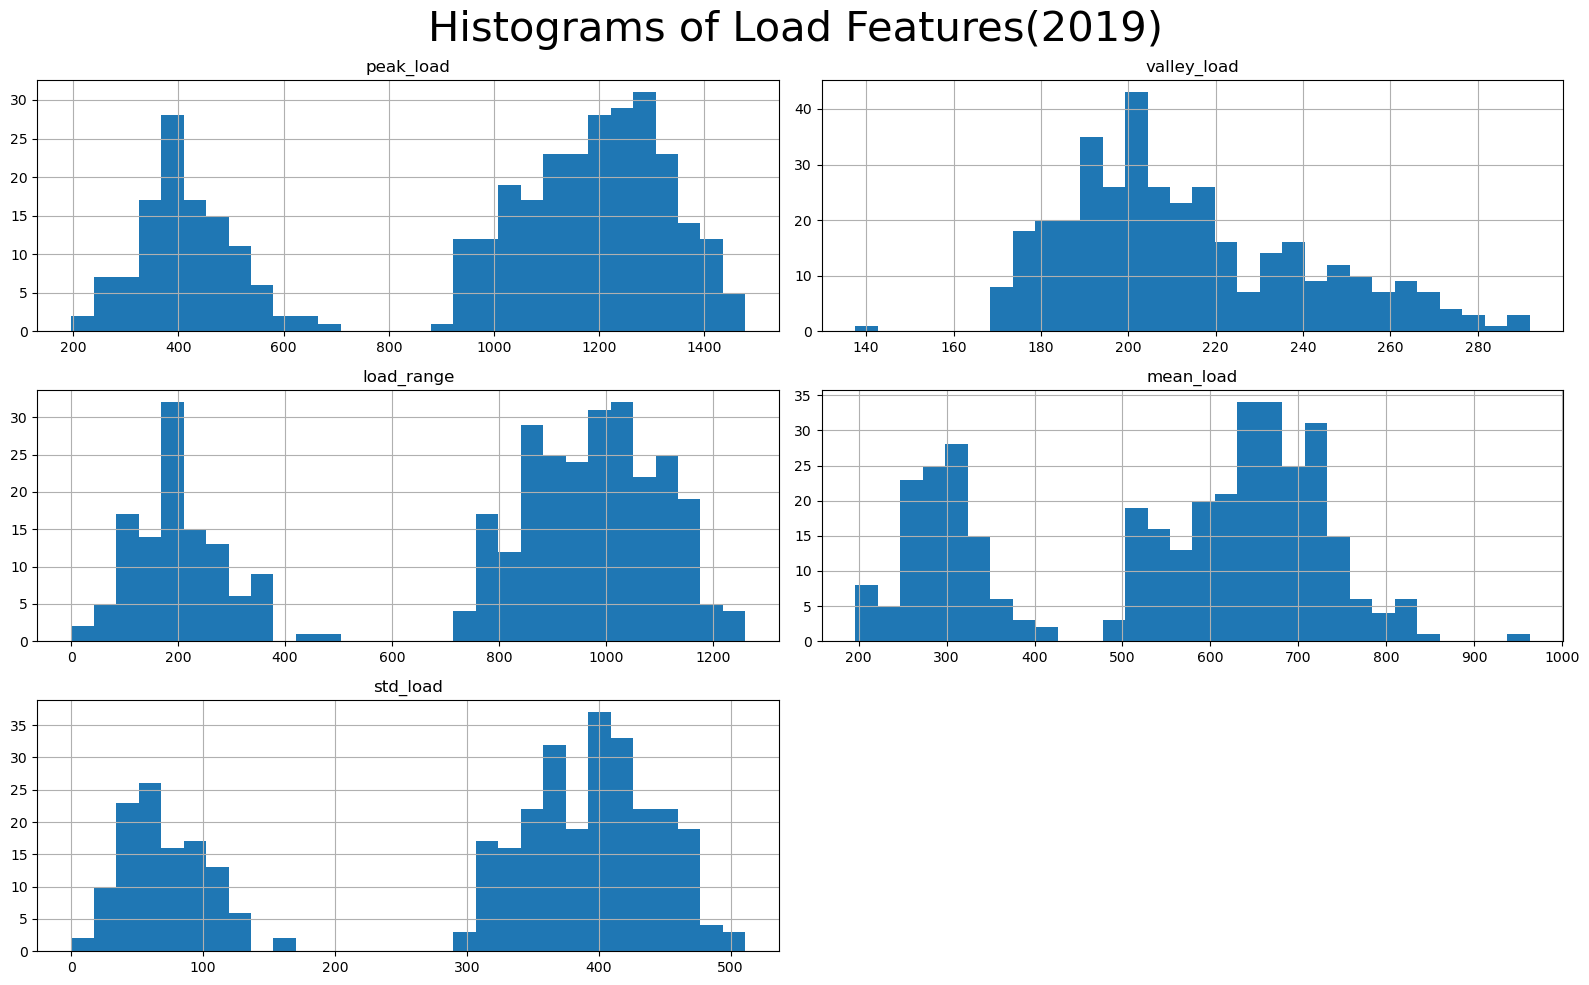

In [43]:
feature_df = pd.DataFrame(index=pivot_df_interp.index)

# 选择中间的负载列（避开 date, cluster 等）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

feature_df['peak_load'] = pivot_df_interp[load_columns].max(axis=1)
feature_df['valley_load'] = pivot_df_interp[load_columns].min(axis=1)
feature_df['load_range'] = feature_df['peak_load'] - feature_df['valley_load']
feature_df['mean_load'] = pivot_df_interp[load_columns].mean(axis=1)
feature_df['std_load'] = pivot_df_interp[load_columns].std(axis=1)
feature_df['load_factor'] = feature_df['mean_load'] / feature_df['peak_load']
feature_df['peak_time'] = pivot_df_interp[load_columns].idxmax(axis=1)
feature_df['valley_time'] = pivot_df_interp[load_columns].idxmin(axis=1)
plt.figure(figsize=(16, 10))
feature_df[['peak_load', 'valley_load', 'load_range', 'mean_load', 'std_load']].hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Load Features(2019)", fontsize=30)
plt.tight_layout()
plt.show()